# Advanced Lane Finding Notebook #
This project calibrates images from a vehicles central camera for use in detecting lanes.

## Lane Finding Pipeline ##

### Imports and Constants ###

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import operator
import random
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Display Functions ###

In [2]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=20) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=20)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotStacked(img1, img2, combined, title1, title2, 
                cmap1=None, cmap2='gray'):
    # Stack each channel to view contributions
    stacked = np.dstack((np.zeros_like(img1), img1, img2))
    plotMany(1, 2, [stacked,combined], [title1,title2], [cmap1,cmap2])
    return

def plotWithVerticles(img, offset, title, cmap=None):
    plt.imshow(img, cmap=cmap)
    xL = offset
    xR = img.shape[1]-offset
    plt.plot((xL, xL), (0, img.shape[0]), 'r-')
    plt.plot((xR, xR), (0, img.shape[0]), 'r-')
    plt.title(title)
    plt.show()
    return

def plotWithSecondOrder(img, leftCoeff, rightCoeff, title):
    y = np.linspace(0, img.shape[0]-1, img.shape[0] )
    xLeft = leftCoeff[0]*y**2 + leftCoeff[1]*y + leftCoeff[2]
    xRight = rightCoeff[0]*y**2 + rightCoeff[1]*y + rightCoeff[2]

    plt.imshow(img, cmap='gray')
    plt.plot(xLeft, y, color='yellow')
    plt.plot(xRight, y, color='yellow')
    plt.ylim(img.shape[0], 0)
    plt.xlim(0, img.shape[1])
    plt.title(title)
    plt.show()
    return

### Testing Images ###
Load the images used to prove out the lane finding pipeline

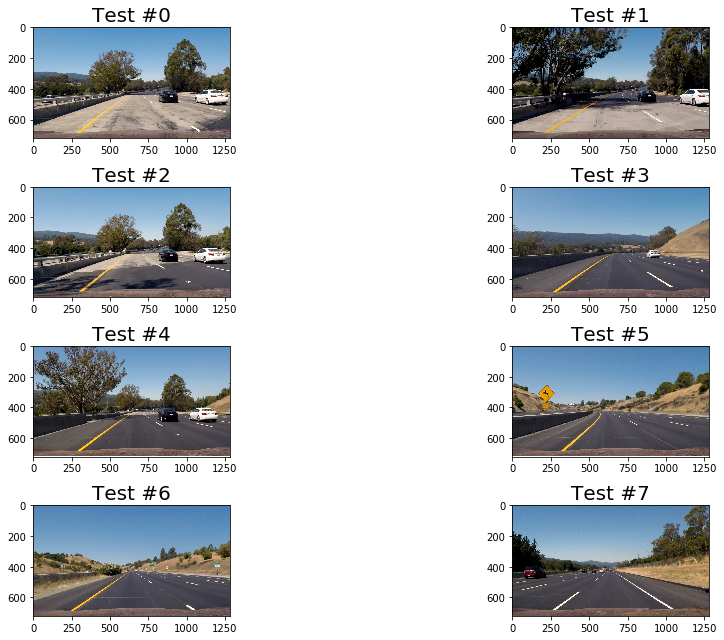

In [3]:
def getTestingImages(pathname):
    files = glob.glob(pathname)
    images = []
    for fname in files:
        img = mpimg.imread(fname)
        images.append(img)
    return images

testImages = getTestingImages('test_images/test*.jpg')  
testImages = testImages+getTestingImages('test_images/straight_lines*.jpg')
testTitles = []
testCmap = []
for i in range(0, len(testImages)):
    testTitles.append("Test #{}".format(i))
    testCmap.append(None)
    
plotMany(4, 2, testImages, testTitles, testCmap)

### Camera Calibration ###
Prior to executing the lane finding pipeline, the camera must be calibrated using 9x6 chessboard images.  This is only completed once.

_Globals and Functions for calibration:_

In [4]:
nx = 9
ny = 6

worldPoints = []
worldPt = np.zeros((nx*ny,3), np.float32)
worldPt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

imagePoints = []

def findChessboardPoints(fname):
    # Find the chessboard corners of file.
    iRGB = mpimg.imread(fname)
    
    # Search for the image chessboard points
    gray = cv2.cvtColor(iRGB, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # Store the points if found
    if ret == True:
        worldPoints.append(worldPt)
        imagePoints.append(corners)
        iRGB = cv2.drawChessboardCorners(iRGB, (nx,ny), corners, ret)
    return iRGB

_Testing/Plotting Cell:_

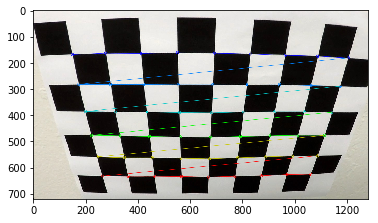

In [5]:
iRGB = findChessboardPoints('camera_cal/calibration2.jpg')
plt.imshow(iRGB)

Process all the provided calibration images and run the calibration.

In [6]:
images = glob.glob('camera_cal/calibration*.jpg')
for chessboard in images:
    findChessboardPoints(chessboard)

print("Calibration points found in {} of {} images".
      format(len(imagePoints), len(images)))

ret, cameraMtx, distCoeffs, rotVecs, transVecs = cv2.calibrateCamera(
    worldPoints, imagePoints, iRGB.shape[0:2], None, None)

Calibration points found in 18 of 20 images


### Lane Finding Pipeline ###
1. Distortion correction
2. Binary image threshold creation
3. Perspective transformation
4. Lane line identification
5. Curvature and location estimation

#### Distortion Correction ####
_Functions for undistortion:_

In [7]:
def undistortImage(img):
    # Undistort the image by refining the camera matrix,
    # running the function, then cropping to the region of interest
    h,w = img.shape[:2]
    newMtx, roi = cv2.getOptimalNewCameraMatrix(cameraMtx, distCoeffs,
                                                (w,h), 1, (w,h))
    undist = cv2.undistort(img, cameraMtx, distCoeffs, None, newMtx)
    x,y,w,h = roi
    return undist[y:y+h, x:x+w]

_Testing/Plotting Cell:_

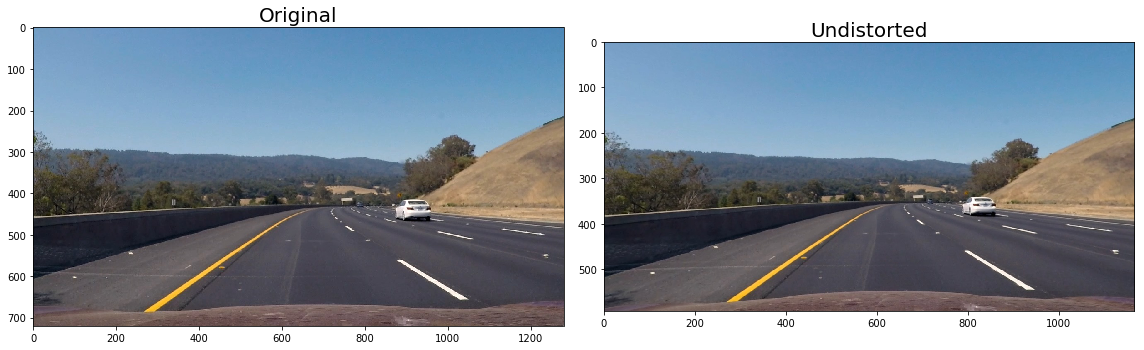

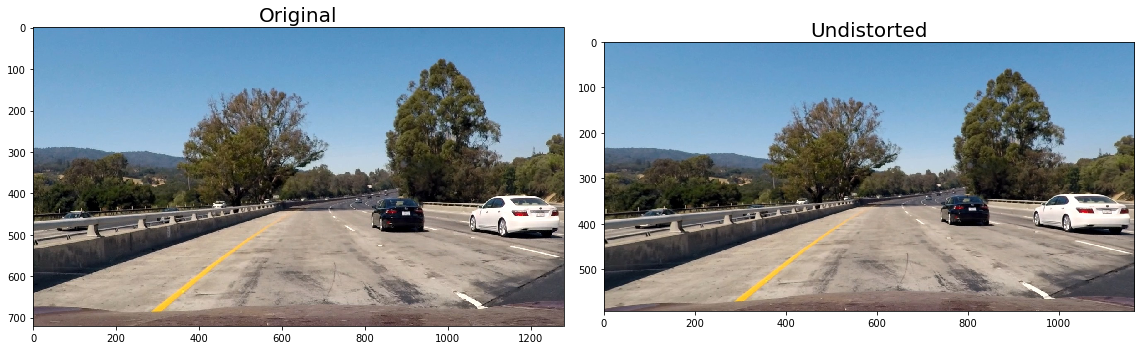

In [8]:
testUndistorteds = []
for img in testImages:
    testUndistorteds.append(undistortImage(img))

samples = random.sample(testImages, 2)
plotTwo(samples[0], undistortImage(samples[0]),
        'Original', 'Undistorted')
plotTwo(samples[1], undistortImage(samples[1]),
        'Original', 'Undistorted')

#### Binary Image Threshold Creation ####
_Functions to create filtered binary images:_  

In [9]:
# ThresholdTesting.ipynb used to determine the following:
SobelKSize = 9
SobelThresh = (50,255)
SobelThreshDir = (0.5, 1.2)
SaturationThresh = (170,255)

def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient, sobel_kernel, thresh):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel, thresh):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel, thresh):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyThresholdSaturation(img, thresh):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyAllThresholds(img):
    # Apply all possible thresholds
    gradx = applyThresholdSobelAbs(img, 'x', SobelKSize, SobelThresh)
    grady = applyThresholdSobelAbs(img, 'y', SobelKSize, SobelThresh)
    magB = applyThresholdSobelMag(img, SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    satB = applyThresholdSaturation(img, SaturationThresh)
    return gradx, grady, magB, dirB, satB   

_Testing/Plotting Cells:_

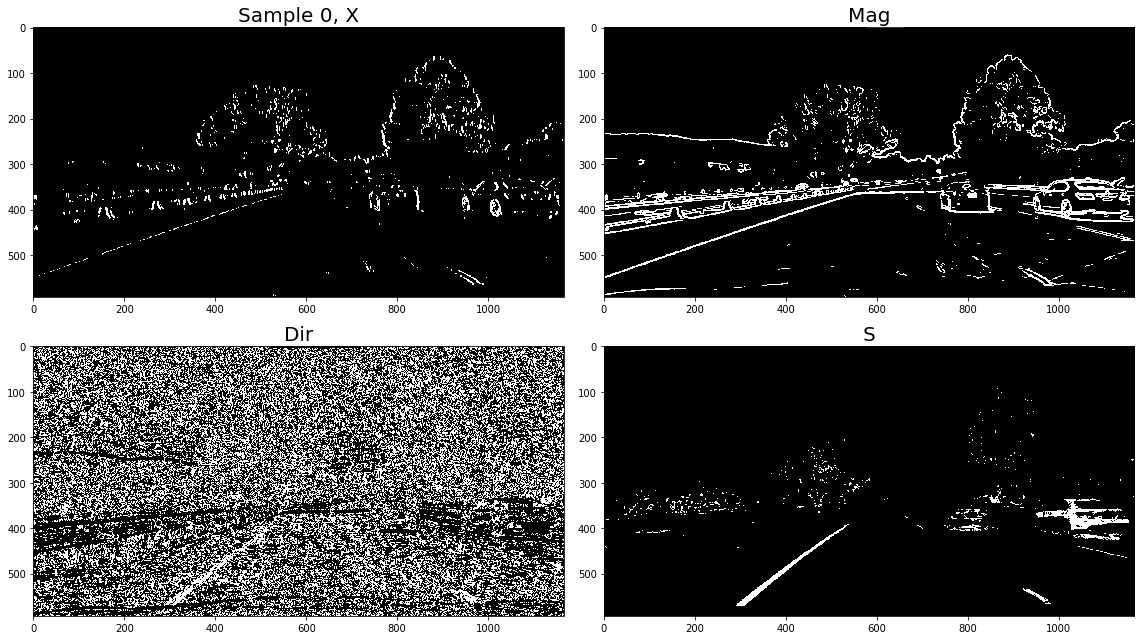

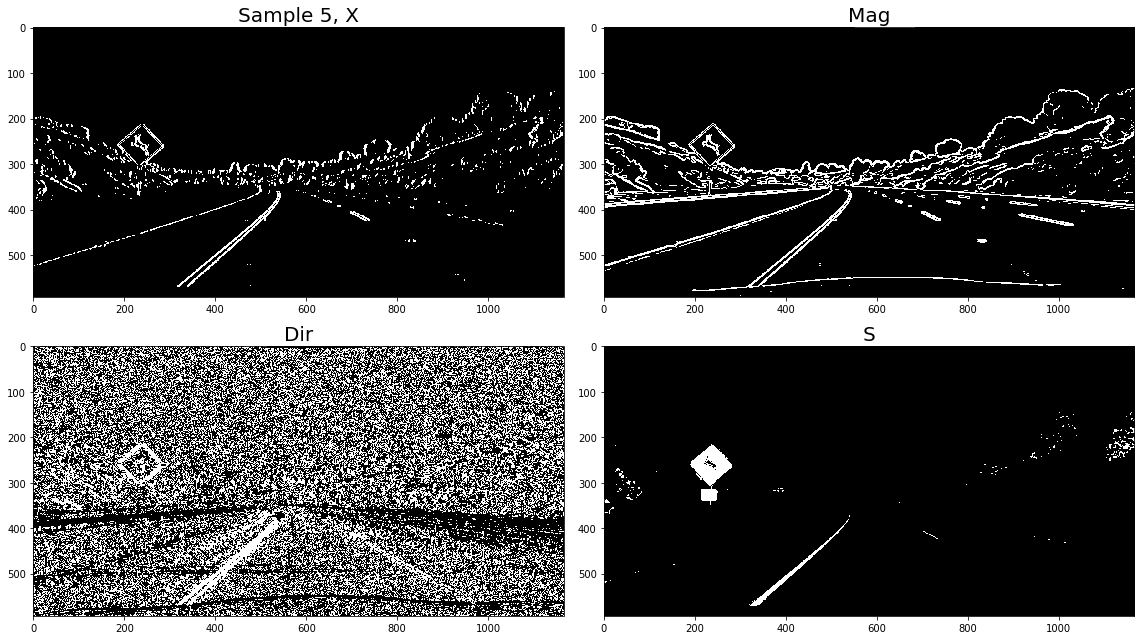

In [10]:
samples = [0, 5]
grayMaps = ['gray','gray','gray','gray']

for idx, img in enumerate(testUndistorteds):
    # Run all the threshold calculations
    gradx, grady, magB, dirB, satB = applyAllThresholds(img)
    
    if idx in samples:
        plotMany(2, 2, [gradx,magB,dirB,satB],
                ["Sample {}, X".format(idx),'Mag','Dir','S'],
                 grayMaps)

_Functions to combine filtered binary images:_ 

In [11]:
def combineThresholds(img):
    # Combine thresholds for pipeline use
    gradx = applyThresholdSobelAbs(img, 'x', SobelKSize, SobelThresh)
    dirB = applyThresholdSobelDir(img, SobelKSize, SobelThreshDir)
    satB = applyThresholdSaturation(img, SaturationThresh)
    
    combine1 = np.zeros_like(dirB)
    combine1[((gradx == 1) & (dirB == 1))] = 1
    combine2 = np.zeros_like(dirB)
    combine2[((satB == 1) & (dirB == 1))] = 1
    
    combined = np.zeros_like(satB)
    combined[(combine1 == 1) | (combine2 == 1)] = 1 
    return combine1, combine2, combined 

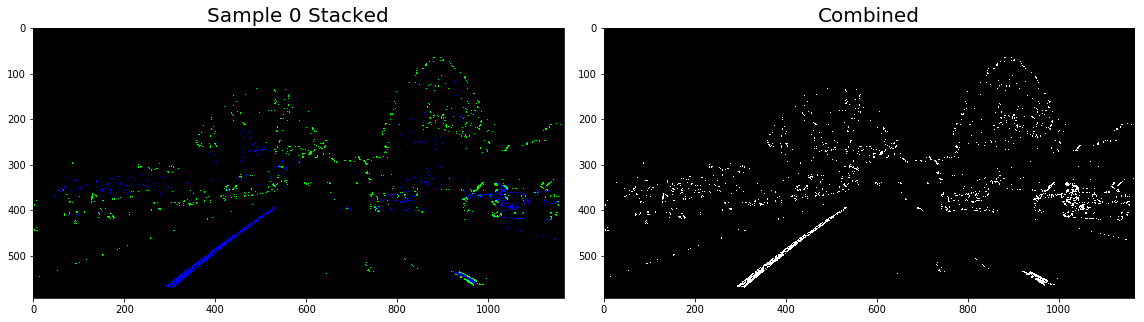

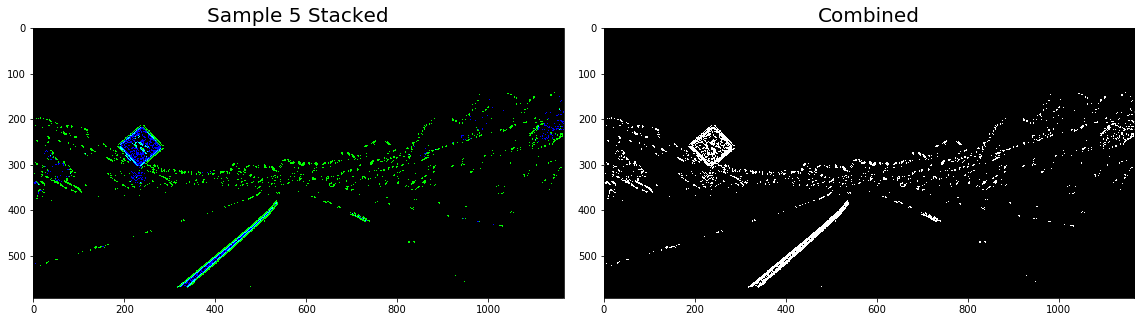

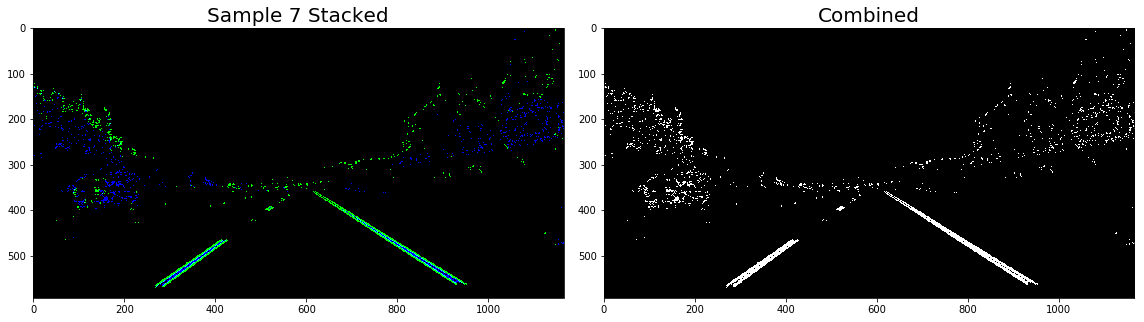

In [12]:
samples = [0, 5, 7]
testCombined = []

for idx, img in enumerate(testUndistorteds):
    # Create the combined threshold
    combine1, combine2, combined = combineThresholds(img)
    testCombined.append(combined)
    
    if idx in samples:
        plotStacked(combine1, combine2, combined, 
                    "Sample {} Stacked".format(idx), "Combined")

#### Perspective Transformation ####
_Functions to transform the perspective of the image:_ 

In [13]:
birdsEyeOffset = 200

def warpToBirdsEye(img):
    # Perform a perspective transform for the region of interest
    # using the values calculated above
    left_top = (539, 380)
    left_bottom = (258, 560)
    right_top = (653, 380)
    right_bottom = (962, 560)    
    birdsEyeSrc = np.float32([left_top, right_top, 
                              right_bottom, left_bottom])
    img_size = (img.shape[1], img.shape[0]) 
    birdsEyeDst = np.float32([[birdsEyeOffset, 0], #L top
                 [img_size[0]-birdsEyeOffset, 0], #R top
                 [img_size[0]-birdsEyeOffset, img.shape[0]], #R bottom 
                 [birdsEyeOffset, img.shape[0]] #L bottom
                 ])  
    M = cv2.getPerspectiveTransform(birdsEyeSrc, birdsEyeDst)
    return cv2.warpPerspective(img, M, img_size)

_Testing/Plotting Cells:_

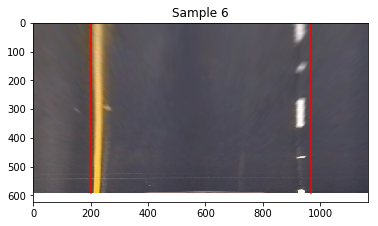

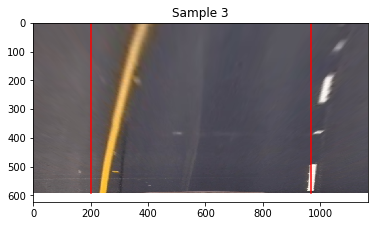

In [14]:
iStraight = warpToBirdsEye(testUndistorteds[6])
plotWithVerticles(iStraight, birdsEyeOffset, 'Sample 6')

iCurve = warpToBirdsEye(testUndistorteds[3])
plotWithVerticles(iCurve, birdsEyeOffset, 'Sample 3')

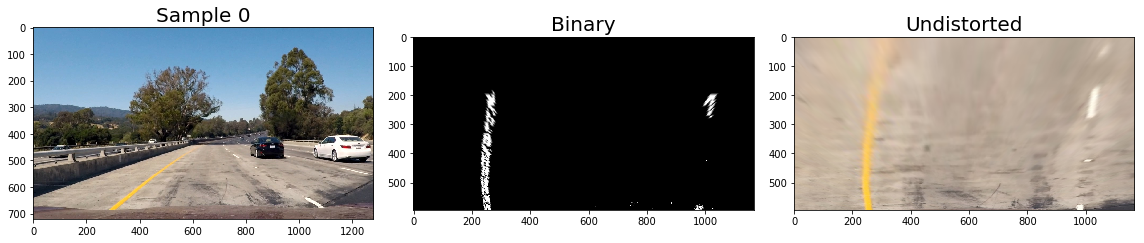

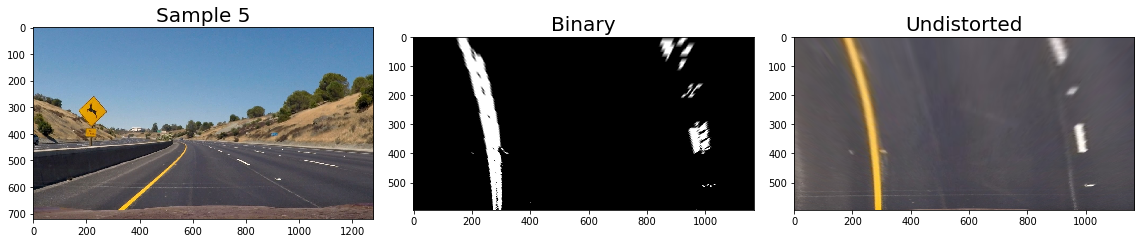

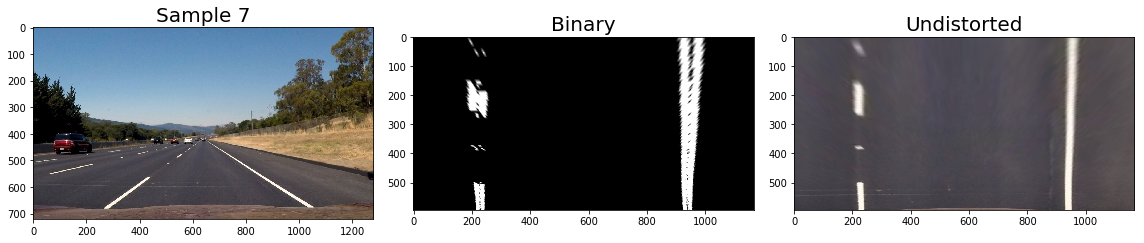

In [15]:
testBirdsEye = []

for idx, img in enumerate(testCombined):
    # Perform the perspective
    warped = warpToBirdsEye(img)
    testBirdsEye.append(warped)
    
    if idx in samples:
        cwarped = warpToBirdsEye(testUndistorteds[idx]) 
        plotMany(1, 3, [testImages[idx], warped, cwarped], 
                 ["Sample {}".format(idx), "Binary", "Undistorted"],
                 [None, 'gray', None])

#### Lane Line Identification ####
_Functions to find the lane lines within the images:_ 

In [16]:
n_windows = 8
windowHeight = np.int(img.shape[0]/n_windows)
windowWidth = 140

def findLaneStarts(img):
    # Calculate the histogram to use the peaks 
    # as the start of the lanes
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    center = np.int(histogram.shape[0]/2)
    xLeft = np.argmax(histogram[:center])
    xRight = center + np.argmax(histogram[center:])
    return xLeft, xRight

def findLaneInWindow(x, y, nonzero):
    # Find the individual lane within the window
    recenterThresh = 10
    y_nonzero = np.array(nonzero[0])
    x_nonzero = np.array(nonzero[1])

    # Locate one lane within the frame of a window
    windowHalfWidth = int(windowWidth/2)
    windowLeft = x - windowHalfWidth;
    windowRight = x + windowHalfWidth
    windowTop = y - windowHeight
    windowBottom = y
    
    # Find the nonzero pixels in x and y within the window
    laneIdx = ((y_nonzero >= windowTop) & 
               (y_nonzero < windowBottom) & 
               (x_nonzero >= windowLeft) &  
               (x_nonzero <= windowRight)).nonzero()[0]
    
    if len(laneIdx) > recenterThresh:
        x = np.int(np.mean(x_nonzero[laneIdx]))
        
    return x, laneIdx, (windowLeft, windowBottom)

def findLaneInImageWindows(nonzero, imageHeight, xStart, 
                           visualizeOn=False):
    # Find the individual lane within the image by
    # looking through windows
    y_nonzero = np.array(nonzero[0])
    x_nonzero = np.array(nonzero[1])
    laneIndices = []
    
    # Step through the windows one by one
    x = xStart
    for w in range(n_windows+1):
        y = imageHeight-(w)*windowHeight
        x, idx, windowCorner = findLaneInWindow(x, y, nonzero)
        laneIndices.append(idx)
        
        # Plot rectangles if enabled
        if visualizeOn:
            windowFrame = patches.Rectangle(windowCorner, 
                                            windowWidth, 
                                            windowHeight, 
                                            fill=False, 
                                            edgecolor='green')
            plt.gca().add_patch(windowFrame)
    
    # Flatten the indices to fit the polynomial
    laneIndices = np.concatenate(laneIndices)
    laneCoeff = np.polyfit(y_nonzero[laneIndices],
                           x_nonzero[laneIndices], 2)    
    return laneCoeff, x_nonzero[laneIndices], y_nonzero[laneIndices]

def findLaneInImage(img, laneCoeff, xStart, visualizeOn=False):
    # Find the individual lane within the image by either
    # looking in the windows or using the second order polynomial
    margin = 100
    nonzero = img.nonzero()
    
    if laneCoeff == []:
        laneCoeff, xs, ys = findLaneInImageWindows(nonzero, 
                                                   img.shape[0], 
                                                   xStart, 
                                                   visualizeOn)
    else:
        y_nonzero = np.array(nonzero[0])
        x_nonzero = np.array(nonzero[1])
        laneIndices = (
            (x_nonzero > 
            (laneCoeff[0]*(y_nonzero**2) + 
             laneCoeff[1]*y_nonzero + laneCoeff[2] - margin)) 
            & 
            (x_nonzero < 
            (laneCoeff[0]*(y_nonzero**2) + 
             laneCoeff[1]*y_nonzero + laneCoeff[2] + margin))) 

        # Fit the polynomial to the new indices
        xs = x_nonzero[laneIndices]
        ys = y_nonzero[laneIndices]
        laneCoeff = np.polyfit(ys, xs, 2)
    return laneCoeff, xs, ys

_Testing/Plotting Cells:_

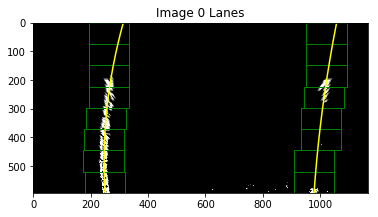

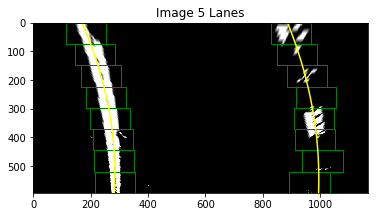

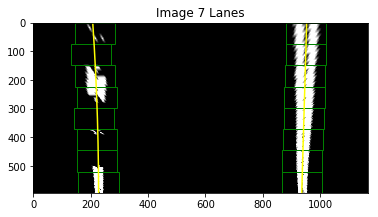

In [17]:
for idx, img in enumerate(testBirdsEye):
    if idx in samples:
        # Find the lanes
        xLeft, xRight = findLaneStarts(img)    
        leftCoeff, xs, ys = findLaneInImage(img, [], xLeft, True)
        rightCoeff, xs, ys = findLaneInImage(img, [], xRight, True)
        plotWithSecondOrder(img, leftCoeff, rightCoeff, 
                            "Image {} Lanes".format(idx))

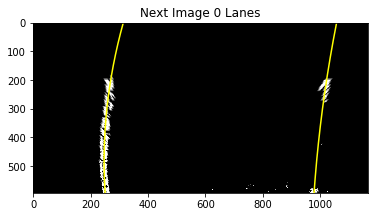

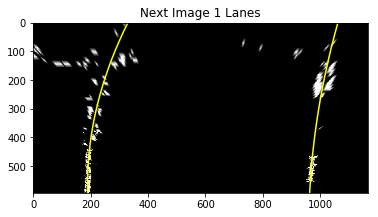

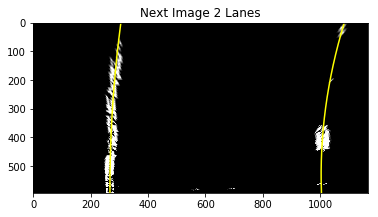

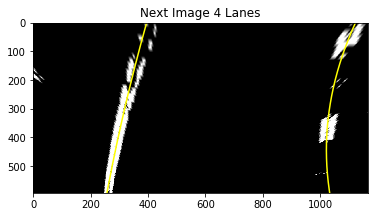

In [18]:
# Use Image 0 as the start 
xLeftStart, xRightStart = findLaneStarts(testBirdsEye[0])    
leftCoeff = []
rightCoeff = []
    
track = [0,1,2,4]
for idx, img in enumerate(testBirdsEye):
    if idx in track:
        leftCoeff, xs, ys = findLaneInImage(img, leftCoeff, xLeftStart)
        rightCoeff, xs, ys = findLaneInImage(img, rightCoeff, xRightStart)
        plotWithSecondOrder(img, leftCoeff, rightCoeff, 
                            "Next Image {} Lanes".format(idx))        

#### Curvature and Location Estimation ####
_Functions to determine the lane curvature within the images:_ 

In [19]:
def calculateCurve(xs, ys):
    # Convert the valid index values to real world to fit
    # a polynomial to use to calculate the radius
    M_PER_PIXEL_y = 30/720 # meters per pixel in y dimension
    M_PER_PIXEL_x = 3.7/700 # meters per pixel in x dimension
    
    worldCoeff = np.polyfit(ys*M_PER_PIXEL_y, xs*M_PER_PIXEL_x, 2)
    y_eval = np.max(xs)
    return ((1+(2*worldCoeff[0]*y_eval*M_PER_PIXEL_y + 
                    worldCoeff[1])**2)**1.5)/np.absolute(2*worldCoeff[0])
    

_Testing/Plotting Cells:_

In [20]:
xLeftStart, xRightStart = findLaneStarts(testBirdsEye[0])    
leftCoeff = []
rightCoeff = []
    
track = [0,1]
for idx, img in enumerate(testBirdsEye):
    if idx in track:
        leftCoeff, xs, ys = findLaneInImage(img, leftCoeff, xLeftStart)
        leftCurve = calculateCurve(xs, ys)
        rightCoeff, xs, ys = findLaneInImage(img, rightCoeff, xRightStart)
        rightCurve = calculateCurve(xs, ys)
        print("Image {} Left:{} m, Right:{} m".format(idx, leftCurve, rightCurve))  

Image 0 Left:573.8497946256097 m, Right:1527.225602867133 m
Image 1 Left:372.993408858084 m, Right:845.5127444302357 m


### Marking lane lines on images ###
First create a class to store the line information

In [30]:
class LaneLine():
    def __init__(self, xStart):
        # was the line detected in the last iteration?
        self.detected = False
        
        # seed x value
        self.xSeed = xStart
        
        # x values of the last fit of the line
        self.xLatest = [] 
        
        #x values moving average
        self.xAvg = None  
        
        #x values for all detected line pixels
        self.xAll = None
                                
        #y values for detected line pixels
        self.yAll = None
        
        #polynomial coefficients for the most recent fit
        self.coeff = [] 
 
        #polynomial coefficients moving average
        self.coeffAvg = np.array([0,0,0], dtype='float')  
               
        #polynomial coefficient delta from last calculation
        self.coeffDelta = np.array([0,0,0], dtype='float')   
        
        #radius of curvature of the line
        self.radius_m = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
    def update(self, coeff, xs, ys):
        self.coeffDelta = np.subtract(self.coeff, coeff)
        self.coeffAvg = np.divide(np.add(self.coeffAvg, coeff),2)
        self.coeff = coeff
        self.xAll.extend(xs)
        self.xAvg = (self.xAvg + np.average(xs))/2
        self.xLatest = xs
        self.yAll.extend(ys)
        return
    
    def findInImage(self, img):
        coef, xs, ys = findLaneInImage(img, self.coeff, self.xSeed)
        self.detected = (xs == [])
        if self.detected:
            self.update(coef, xs, ys)
            self.radius_m = calculateCurve(xs, ys)
        

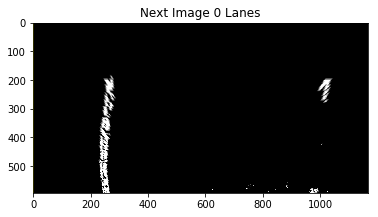

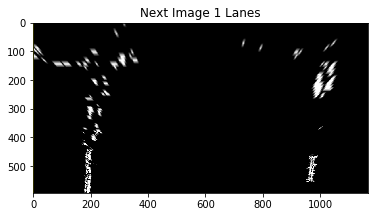

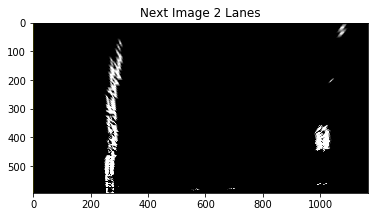

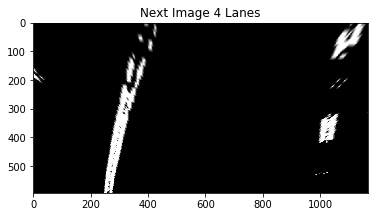

In [32]:
xLeftStart, xRightStart = findLaneStarts(testBirdsEye[0])    

leftLane = LaneLine(xLeftStart)
rightLane = LaneLine(xRightStart)
    
track = [0,1,2,4]
for idx, img in enumerate(testBirdsEye):
    if idx in track:
        leftLane.findInImage(img)
        rightLane.findInImage(img)
        plotWithSecondOrder(img, leftLane.coeffAvg, rightLane.coeffAvg, 
                            "Next Image {} Lanes".format(idx))


## Video Processing ##

This section of the notebook processes the test videos

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))